In [1]:
import numpy as np
from numba import jit # this is only to speed up for loops in functions. Can be ignored
import matplotlib.pyplot as plt
%matplotlib inline

# Exercise 1

Write your own routine for creating the monomial basis matrix in one
dimension, that takes nodes, degree and boundaries of the approximation as
inputs and returns a conforming matrix

In [2]:
@jit
def mono_basex(p, x): 
    """Monomials basis matrix- for 1 dimension.

    Returns a matrix whose columns are the values of the monomials of maximum 
    order n - 1 evaluated at the points `x`. Degree 0 is the constant 0.

    Parameters
    ----------
    p : array_like
        Parameter array containing:
         - the order of approximation - the highest degree polynomial is n-1
         - the lower bound of the approximation
         - the upper bound of the approximation
    x : array_like
        Points at which to evaluate the basis functions.

    Returns
    -------
    bas : ndarray
        Matrix of shape (m,n), where ``m = len(x)`` and
        ``n - 1 = order(polynomial)``

    Notes
    -----
    Also known as the Vandermonde matrix
    """
    n , a , b = p[0] , p[1] , p[2]
    z = (2/(b-a)) * (x-(a+b)/2)
    m = z.shape[0]
    bas = np.empty((m, n));
    bas[:, 0] = 1.0
    for i in range(m):
        for j in range(1,n):
            bas[i, j] = z[i] * bas[i, j-1]
    return bas

# Exercise 2

Use this to approximate Runge's function $\frac{1}{1 + 25 x^2}$ using 20 nodes on  $ [-1,1] $. Place the nodes as you wish. Plot the approximation error (relative to a fine grid with at least $ 100 $ nodes)

First, create a function that returns one dimensional Chebyshev nodes

In [3]:
@jit
def cheb_nodes(p, nodetype=0):
    """Chebyshev nodes - for 1 dimension.

    Returns Chebyshev nodes

    Parameters
    ----------
    p : array_like
        Parameter array containing:
         - the number of nodes
         - the lower bound of the approximation
         - the upper bound of the approximation
    nodetype : int
         - if 0 (default value) then use the usual nodes
         - if 1 then extend it to the endpoints
         - if 2 then us Lobatto nodes

    Returns
    -------
    x :  an array containing the Chebyshev nodes

    Notes
    -----
    """    
    n , a , b = p[0] , p[1] , p[2]
    s = (b-a) / 2 
    m = (b+a) / 2  
    if (nodetype < 2):  # usual nodes
        k = np.pi*np.linspace(0.5,n-0.5,n)  
        x = m - np.cos(k[0:n]/n) * s  
        if (nodetype == 1):  # Extend nodes to endpoints
            aa = x[0]  
            bb = x[-1]  
            x = (bb*a - aa*b)/(bb-aa) + (b-a)/(bb-aa)*x
    else: # Lobatto nodes
        k = np.pi*np.linspace(0,n-1,n)
        x = m - np.cos(k[0:n]/(n-1)) * s
    return x

Lets see how it looks like for equidistant nodes

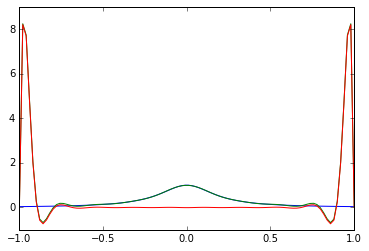

In [4]:
n = 20
p = (n,-1,1)
x = np.linspace(-1,1,n)
y = 1/(1 + 25* x**2)
Phi=mono_basex(p,x)
coeff = np.linalg.solve(Phi,y)
x1 = np.linspace(-1,1,100)
y1 = 1/(1 + 25* x1**2)
Phi1 = mono_basex(p,x1)
y_approx = Phi1 @ coeff
plt.plot(x1,y1)
plt.plot(x1,y_approx)
plt.plot(x1,y_approx - y1)
plt.show()

Not that great, especially towards the end of the intervals. Lets try Chebyshev nodes

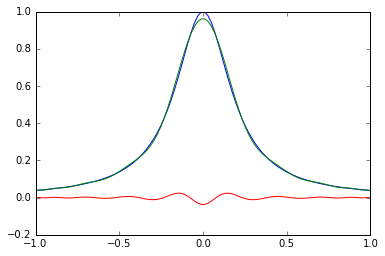

In [5]:
n = 20
p = (n,-1,1)
x = cheb_nodes(p,0)
y = 1/(1 + 25* x**2)
Phi=mono_basex(p,x)
coeff = np.linalg.solve(Phi,y)
x1 = np.linspace(-1,1,100)
y1 = 1/(1 + 25* x1**2)
Phi1 = mono_basex(p,x1)
y_approx = Phi1 @ coeff
plt.plot(x1,y1)
plt.plot(x1,y_approx)
plt.plot(x1,y_approx - y1)
plt.show()

# Exercise 3

Create a difference operator for the monomials that takes the degree and boundaries of the approximation as inputs and returns a matrix that if multiplied from the right ( $ \Phi \cdot D $ ) returns the derivative matrix

In [6]:
@jit
def mono_diff(p):  
    """Differentiating matrix for monomials

    Returns a matrix which multiplied from the right with the coefficients
    of the monomial returns the derivative of the respective 
    monomial. Can be used instead to evaluate the basis matrix of
    the derivative of a monomial.

    Parameters
    ----------
    p : array_like
        Parameter array containing:
         - the number of knots = degree + 1 of the polynomial
         - the lower bound of the approximation
         - the upper bound of the approximation
    Returns
    -------
    D : ndarray
       Returns an upper triangular derivative operator matrix 

    Notes
    -----
    """
    n , a , b = p[0] , p[1] , p[2] 
    D = np.zeros((n,n))
    for j in range(n-1):
        D[j,j+1] = (j+1)/(b-a)*2
    return D

# Exercise 4

Use the coefficients you obtained from Part 2) and the difference operator to approximate the derivative of Runge's function ($ \frac{-50 x}{(1 + 25 * x^2)^2}$) and plot the errors

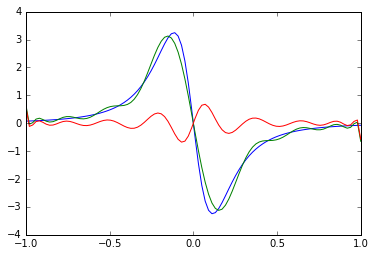

In [7]:
x1 = np.linspace(-1,1,100)
y1 = -50* x1/(1 + 25* x1**2)**2 
Phi1 = mono_basex(p,x1) @ mono_diff(p)
y_approx = Phi1 @ coeff
plt.plot(x1,y1)
plt.plot(x1,y_approx)
plt.plot(x1,y_approx - y1)
plt.show()

# Exercise 5 

Approximate the banana function $ (1 - x_1)^2 + 100 (x_2 - x_1^2)^2$ between $[-3,3] \times [-3,3]$ using monomials and $20$ nodes in each dimensions.

In [8]:
n_1 = 20
n_2 = 20
P = np.array(((n_1,-3,3),(n_2,-3,3)))
x_1 = cheb_nodes(P[0],0)
x_2 = cheb_nodes(P[1],0)
x_1 = np.reshape(x_1,(n_1,1))
x_2 = np.reshape(x_2,(n_2,1))
s = np.concatenate((np.kron(np.ones((n_2,1)),x_1),np.kron(x_2,np.ones((n_1,1)))),1)
#The banana - vectorized
def Banana(s):
    return (1-s[:,0])**2 + 100 * (s[:,1]-s[:,0]**2)**2
y = Banana(s)
Phi1 = mono_basex(P[0],x_1)
Phi2 = mono_basex(P[1],x_2)
Phi3 = np.kron(Phi2,Phi1)
coeff = np.linalg.solve(Phi3,y)
#Generate the approximand
n1 = 200
n2 = 200
x1 = np.linspace(-3,3,n1)
x2 = np.linspace(-3,3,n2)
x1 = np.reshape(x1,(n1,1))
x2 = np.reshape(x2,(n2,1))
s1 = np.concatenate((np.kron(np.ones((n2,1)),x1),np.kron(x2,np.ones((n1,1)))),1)
y1 = Banana(s1)
Phi1a = mono_basex(P[0],x1)
Phi2a = mono_basex(P[1],x2)
Phi3a = np.kron(Phi2a,Phi1a)
y_approx= Phi3a @ coeff

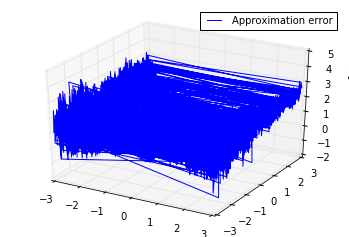

In [9]:
#3D Plot
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
mpl.rcParams['legend.fontsize'] = 10

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(s1[:,0], s1[:,1], y1-y_approx, label='Approximation error')
ax.legend()

plt.show()

A word of caution here: if you are planning on using Compecon toolbox on any language then you should avoid using the built-in Kronecker product function and should use the function called dprod. This enables you to create a larger basis matrix and is more accurate,faster and slightly more flexible.

In [10]:
@jit
def dprod(A,B):
    """calculate tensor product of two matrices
    with the same number of rows
    
    Parameters
    ----------
    A : array_like
        In multidimensional approximation this is the 
        1 dimensional basis matrix
    B: array_like
        In multidimensional approximation this is the 
        n - 1 dimensional basis matrix

    Returns
    -------
    Res :  ndarray
        Matrix of shape (m,n), where m = no. rows in A and
        n = no. columns in A * no. columns in B

    Notes
    -----
    """

    nobsa , na = A.shape
    nobsb , nb = B.shape
    Res = np.empty((nobsa,nb*na))
    if nobsa != nobsb:
        return 'A and B must have same number of rows'
    for t in range(nobsa):
        for ia in range(na):
            for ib in range(nb):            
                Res[t,nb*(ia-1)+ib] = A[t,ia] * B[t, ib]
    return Res

In [11]:
n_1 = 20
n_2 = 20
P = np.array(((n_1,-3,3),(n_2,-3,3)))
x_1 = cheb_nodes(P[0],0)
x_2 = cheb_nodes(P[1],0)
x_1 = np.reshape(x_1,(n_1,1))
x_2 = np.reshape(x_2,(n_2,1))
s = np.concatenate((np.kron(np.ones((n_2,1)),x_1),np.kron(x_2,np.ones((n_1,1)))),1)
#The banana - vectorized
def Banana(s):
    return (1-s[:,0])**2 + 100 * (s[:,1]-s[:,0]**2)**2
y = Banana(s)
Phi1 = mono_basex(P[0],s[:,0])
Phi2 = mono_basex(P[1],s[:,1])
Phi3 = dprod(Phi2,Phi1)
coeff = np.linalg.solve(Phi3,y)
#Generate the approximand
n1 = 200
n2 = 200
x1 = np.linspace(-3,3,n1)
x2 = np.linspace(-3,3,n2)
x1 = np.reshape(x1,(n1,1))
x2 = np.reshape(x2,(n2,1))
s1 = np.concatenate((np.kron(np.ones((n2,1)),x1),np.kron(x2,np.ones((n1,1)))),1)
y1 = Banana(s1)
Phi1a = mono_basex(P[0],s1[:,0])
Phi2a = mono_basex(P[1],s1[:,1])
Phi3a = dprod(Phi2a,Phi1a)
y_approx= Phi3a @ coeff

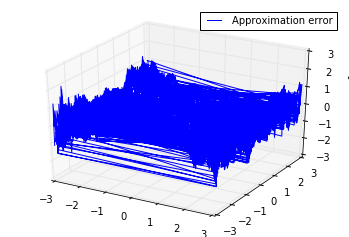

In [12]:
#3D Plot
mpl.rcParams['legend.fontsize'] = 10

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(s1[:,0], s1[:,1], y1-y_approx, label='Approximation error')
ax.legend()

plt.show()